In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix


In [79]:
ranked_features = pd.read_csv('RF_feature_importance.csv',index_col=0)
feature_set = ranked_features[:30].index.to_numpy()
feature_set = '|'.join(feature_set)

In [80]:
df = pd.read_csv('processed_data/train_features.csv')

# feature_set = r'^(?!.*rms).*ch.*'
# feature_set = 'ch'
X = df.filter(regex=feature_set, axis=1)
y_train = df['label'].to_numpy()
y_train = y_train - 1

In [81]:
test_df = pd.read_csv('processed_data/test_features.csv')
Xtest = test_df.filter(regex=feature_set, axis=1).to_numpy()
y_test = test_df['label'].to_numpy()
y_test = y_test - 1

In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(Xtest)

/Users/alexiswu/Desktop/neurotech/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [83]:
class EMGClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.7):
        super(EMGClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # nn.Linear(hidden_sizes[0], num_classes),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            # nn.Linear(hidden_sizes[1], num_classes)
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[2], num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)


In [84]:
hidden_sizes = [256,128,64]
batch_size = 32
num_epochs = 150
lr = 0.01
input_size = X_train.shape[1]  # Number of features
num_classes = len(set(y_train))  # Number of classes
model = EMGClassifier(input_size, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)

# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6, verbose=True)

early_stopping_patience = 20  # Number of epochs to wait for improvement before stopping
min_val_loss = float('inf')  # Initialize to infinity; will store the best model's loss
early_stopping_counter = 0  # Counter to keep track of how many epochs without improvement


In [85]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

In [86]:
# Train the model
losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    # Forward pass: Compute predicted y by passing x to the model
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(train_loader)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_corrects = 0
    total = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_val_loss = val_loss / len(validation_loader)
    epoch_val_accuracy = val_corrects.double() / total

    if epoch_val_loss < min_val_loss:
        print(f"Validation loss decreased ({min_val_loss:.6f} --> {epoch_val_loss:.6f}).  Saving model ...")
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
        min_val_loss = epoch_val_loss
        early_stopping_counter = 0  # Reset counter if there is an improvement
    else:
        early_stopping_counter += 1
        print(f"No improvement in validation loss for {early_stopping_counter} epoch(s)...")
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')
    scheduler.step(epoch_val_loss)
    losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)


Validation loss decreased (inf --> 1.086442).  Saving model ...
Epoch 1/150, Train Loss: 1.2240, Validation Loss: 1.0864, Validation Accuracy: 0.3039
Validation loss decreased (1.086442 --> 1.041310).  Saving model ...
Epoch 2/150, Train Loss: 1.0820, Validation Loss: 1.0413, Validation Accuracy: 0.4216
Validation loss decreased (1.041310 --> 0.988540).  Saving model ...
Epoch 3/150, Train Loss: 1.0337, Validation Loss: 0.9885, Validation Accuracy: 0.5833
Validation loss decreased (0.988540 --> 0.924028).  Saving model ...
Epoch 4/150, Train Loss: 0.9640, Validation Loss: 0.9240, Validation Accuracy: 0.6127
Validation loss decreased (0.924028 --> 0.855884).  Saving model ...
Epoch 5/150, Train Loss: 0.8577, Validation Loss: 0.8559, Validation Accuracy: 0.6176
Validation loss decreased (0.855884 --> 0.802525).  Saving model ...
Epoch 6/150, Train Loss: 0.7906, Validation Loss: 0.8025, Validation Accuracy: 0.6422
Validation loss decreased (0.802525 --> 0.773311).  Saving model ...
Epoch 

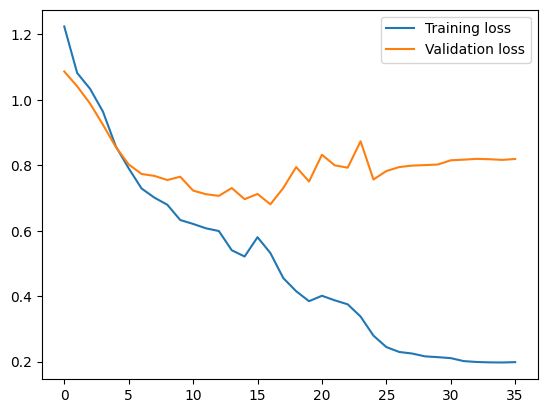

In [87]:
import matplotlib.pyplot as plt
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [88]:

# Evaluate the model
model.eval()  # Set the model to evaluation mode
preds = []
actual = []
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    preds.append(predicted)
    actual.append(y_test_tensor)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    

print('Accuracy of the model on the test set: {} %'.format(100 * correct / total))
f1 = f1_score(y_test_tensor, predicted, average=None)
cm = confusion_matrix(y_test_tensor, predicted,labels=[0,1,2])
print(f"f1 score: {f1}")
print(f"confusion matrix:\n {cm}")

Accuracy of the model on the test set: 73.03921568627452 %
f1 score: [0.72727273 0.75757576 0.70833333]
confusion matrix:
 [[48  8  9]
 [ 5 50  8]
 [14 11 51]]


In [52]:
# torch.save(model.state_dict(), 'models/MLP.pth')
# import joblib
# joblib.dump(scaler, 'models/MLP_scaler.pkl')

['models/MLP_scaler.pkl']

In [91]:
model = EMGClassifier(input_size=48)
model.load_state_dict(dct)

TypeError: EMGClassifier.__init__() missing 2 required positional arguments: 'hidden_sizes' and 'num_classes'

In [94]:
state_dict = torch.load('models/MLP.pth')

In [96]:
# Iterate through the state dictionary and print the shape of each linear layer's weights
for name, param in state_dict.items():
    print(f"Layer {name} has shape: {param.shape}")

Layer layers.0.weight has shape: torch.Size([128, 48])
Layer layers.0.bias has shape: torch.Size([128])
Layer layers.1.weight has shape: torch.Size([128])
Layer layers.1.bias has shape: torch.Size([128])
Layer layers.1.running_mean has shape: torch.Size([128])
Layer layers.1.running_var has shape: torch.Size([128])
Layer layers.1.num_batches_tracked has shape: torch.Size([])
Layer layers.4.weight has shape: torch.Size([32, 128])
Layer layers.4.bias has shape: torch.Size([32])
Layer layers.5.weight has shape: torch.Size([32])
Layer layers.5.bias has shape: torch.Size([32])
Layer layers.5.running_mean has shape: torch.Size([32])
Layer layers.5.running_var has shape: torch.Size([32])
Layer layers.5.num_batches_tracked has shape: torch.Size([])
Layer layers.8.weight has shape: torch.Size([3, 32])
Layer layers.8.bias has shape: torch.Size([3])
